In [ ]:
# Install the necesary libraries
!pip3 install --upgrade --no-cache-dir gdown
!pip3 install transformers
!python -m spacy download en_core_web_sm
!pip3 install gensim==3.8.3
!pip3 install sentence-transformers
!pip3 install rouge

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=87ab3199483d5e148b2a5d5852d9d86e19be0a393f6aa666e293b14d9e25e885
  Stored in directory: /tmp/pip-ephem-wheel-cache-dndcatyz/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.1
    Uninstalling gdown-4.2.1:
      Successfully uninstalled gdown-4.2.1
     |████████████████████████████████| 3.5 MB 4.4 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 31.2 MB/s 
     |████████████████████████████████| 895 kB 37.7 MB/s 
     |████████████████████████████████| 596 kB 23.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyY

In [ ]:
# Import the necessary libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from transformers import PegasusTokenizerFast

import en_core_web_sm
nlp = en_core_web_sm.load()

from gensim.summarization.summarizer import summarize

import torch
from sentence_transformers import SentenceTransformer

import math
from nltk.cluster.util import cosine_distance
from sklearn.neighbors import NearestNeighbors

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from rouge import Rouge
rouge = Rouge()

In [ ]:
# Set the hyperparameters
SUMMARISE = False

# Data Extraction

In [ ]:
# Download the PubMed articles
!gdown --id 194i6OJUokjhwZqaLuxkrENUsozHCCjNa

Downloading...
From: https://drive.google.com/uc?id=194i6OJUokjhwZqaLuxkrENUsozHCCjNa
To: /content/test.txt
100% 251M/251M [00:03<00:00, 66.2MB/s]


In [ ]:
# Extract the text data
data = []
for line in open('/content/test.txt', 'r'):
    data.append(json.loads(line))

# Load the data into a dataframe
df = pd.DataFrame(data)

# Preview the initial dataframe
df.head()

,article_id,article_text,abstract_text,labels,section_names,sections
0,PMC5075302,[anxiety affects quality of life in those livi...,[<S> research on the implications of anxiety i...,None,"[1. Introduction, 2. Methods, 3. Results, 4. D...",[[anxiety affects quality of life in those liv...
1,PMC3309138,[small non - coding rnas are transcribed into ...,"[<S> small non - coding rnas include sirna , m...",None,"[Introduction, Aberrant Expression of miRNA in...",[[small non - coding rnas are transcribed into...
2,PMC4086000,[ohss is a serious complication of ovulation i...,[<S> objective : to evaluate the efficacy and ...,None,"[Introduction, Materials and Methods, Results,...",[[ohss is a serious complication of ovulation ...
3,PMC3603086,[congenital adrenal hyperplasia ( cah ) refers...,[<S> congenital adrenal hyperplasia is a group...,None,"[I, M, R, D]",[[congenital adrenal hyperplasia ( cah ) refer...
4,PMC4414990,[type 1 diabetes ( t1d ) results from the dest...,[<S> objective(s):pentoxifylline is an immunom...,None,"[Introduction, Materials and Methods, Drug and...",[[type 1 diabetes ( t1d ) results from the des...


In [ ]:
# Join the articles and abstracts into single strings
df['Text'] = df['article_text'].str.join(' ')
df['Reference'] = df['abstract_text'].str.join(' ')

# Remove the special tokens
df['Reference'].replace(to_replace='<S>|</S>', value='', regex=True, inplace=True)
df['Reference'] = df['Reference'].str.strip()

In [ ]:
# Keep only the relevant columns
df = df[['Text', 'Reference']]

# Rename the columns
df.columns = ['Text', 'Reference']

# Preview the transformed dataframe
print(f'Number of rows: {df.shape[0]}')
df.head()

Number of rows: 6658


,Text,Reference
0,anxiety affects quality of life in those livin...,research on the implications of anxiety in par...
1,small non - coding rnas are transcribed into m...,"small non - coding rnas include sirna , mirna ..."
2,ohss is a serious complication of ovulation in...,objective : to evaluate the efficacy and safet...
3,congenital adrenal hyperplasia ( cah ) refers ...,congenital adrenal hyperplasia is a group of a...
4,type 1 diabetes ( t1d ) results from the destr...,objective(s):pentoxifylline is an immunomodula...


# Data Analysis

In [ ]:
# Utilised functions
def count_tokens(text, fast_tokeniser):
    return len(fast_tokeniser.tokenize(text))

In [ ]:
# Define the word tokeniser
fast_tokeniser_pegasus = PegasusTokenizerFast.from_pretrained('google/pegasus-pubmed')

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

In [ ]:
# Get the number of tokens per document
df['Tokens'] = df['Text'].progress_apply(count_tokens, args=[fast_tokeniser_pegasus])
df.head()

100%|██████████| 6658/6658 [02:09<00:00, 51.26it/s]


,Text,Reference,Tokens
0,anxiety affects quality of life in those livin...,research on the implications of anxiety in par...,3914
1,small non - coding rnas are transcribed into m...,"small non - coding rnas include sirna , mirna ...",3295
2,ohss is a serious complication of ovulation in...,objective : to evaluate the efficacy and safet...,4768
3,congenital adrenal hyperplasia ( cah ) refers ...,congenital adrenal hyperplasia is a group of a...,1142
4,type 1 diabetes ( t1d ) results from the destr...,objective(s):pentoxifylline is an immunomodula...,4398


In [ ]:
# Calculate the document statistics
print(f"mode       {df['Tokens'].mode()[0]:.6f}")
df['Tokens'].describe()

mode       2003.000000


count      6658.000000
mean       3948.284770
std        3425.464522
min          25.000000
25%        1921.250000
50%        3248.500000
75%        5040.250000
max      108507.000000
Name: Tokens, dtype: float64

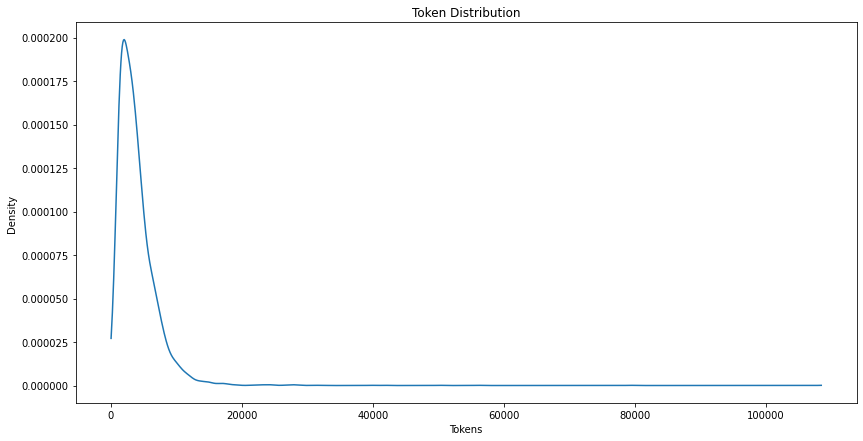

In [ ]:
# Plot the distribution of the total tokens
x_axis = np.arange(df['Tokens'].min(), df['Tokens'].max(), 100)
plt.figure(figsize=(14, 7))
plt.title('Token Distribution')
df['Tokens'].plot.kde(ind=x_axis)
plt.xlabel('Tokens')
plt.show()

# Extractive Summarisation

In [ ]:
# Utilised functions
def extract_trank(row):
    max_tokens = fast_tokeniser_pegasus.max_len_single_sentence - 1
    
    if row['Tokens'] > max_tokens:
        doc = nlp(row['Text'])
        sentences = [sent.text.strip() for sent in doc.sents]

        tokens_per_sent = row['Tokens'] / len(sentences)
        num_sentences = math.floor(max_tokens / tokens_per_sent)
        
        result = summarize(row['Text'], ratio=num_sentences/len(sentences))
        return result
        
    else:
        return row['Text']

def extract_nsearch(row):
    max_tokens = fast_tokeniser_pegasus.max_len_single_sentence - 1
    
    if row['Tokens'] > max_tokens:
        doc = nlp(row['Text'])
        sentences = [sent.text.strip() for sent in doc.sents]

        tokens_per_sent = row['Tokens'] / len(sentences)
        num_sentences = math.floor(max_tokens / tokens_per_sent)

        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        
        sent_vectors = sbert_model.to(device).encode(sentences, show_progress_bar=False)
        centroid = np.mean(sent_vectors, axis=0).reshape(1, -1)

        knn = NearestNeighbors(n_neighbors=num_sentences, metric=cosine_distance, algorithm='brute', n_jobs=-1)
        knn.fit(sent_vectors)

        nearest_sents = knn.kneighbors(centroid, return_distance=False)
        nearest_sents.sort()

        result = ''
        for index, i in enumerate(nearest_sents[0]):
            if index == 0:
                result += sentences[i]
            else:
                result += ' ' + sentences[i]

        return result
    
    else:
        return row['Text']

In [ ]:
if SUMMARISE:
    
    # Get the paragraphs using TRank
    df['TRank'] = df.progress_apply(extract_trank, axis=1)

    # Preview the partial dataset
    df.head()

In [ ]:
if SUMMARISE:

    # Define the SBERT model
    sbert_model = SentenceTransformer('all-mpnet-base-v2')

    # Get the paragraphs using SBERT and NSearch
    df['NSearch'] = df.progress_apply(extract_nsearch, axis=1)

    # Preview the partial dataset
    df.head()

In [ ]:
# Save the dataframe with the extracted texts
if SUMMARISE:
    extracted = df[['Text', 'Reference', 'TRank', 'NSearch']]
    extracted.to_pickle('extracted.pkl')

# Abstractive Summarisation

In [ ]:
# Utilised functions
def summarise(text, tokeniser, model):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    inputs = tokeniser(text, truncation=True, padding='max_length', return_tensors='pt').to(device)
    outputs = model.to(device).generate(inputs['input_ids'])
    
    summary = tokeniser.decode(outputs[0], skip_special_tokens=True)
    return summary

def get_scores(hypotheses, references):
    
    rouge_1, rouge_2, rouge_L = [], [], []

    for i in hypotheses.index:
        scores = rouge.get_scores(hypotheses[i], references[i])[0]
        rouge_1.append(scores['rouge-1']['f'])
        rouge_2.append(scores['rouge-2']['f'])
        rouge_L.append(scores['rouge-l']['f'])

    return rouge_1, rouge_2, rouge_L

In [ ]:
# Read the dataframe with the extracted texts
if SUMMARISE:
  !gdown --id 1NRl7mfVC207QMOmYSiV0_i7i-Wze7ckp
  df = pd.read_pickle('/content/extracted.pkl')
  display(df.head())

In [ ]:
if SUMMARISE:
    
    # Define the summariser model
    tokeniser_pegasus = AutoTokenizer.from_pretrained('google/pegasus-pubmed')
    model_pegasus = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-pubmed')

    # Summarise the extracted texts using the baseline approach
    df['Hypothesis'] = df['Text'].progress_apply(summarise, args=[tokeniser_pegasus, model_pegasus])

    # Remove the <n> tokens
    df['Hypothesis'].replace(to_replace='<n>', value='', regex=True, inplace=True)
    
    # Get the rouge scores for each summary
    df['Rouge_1'], df['Rouge_2'], df['Rouge_L'] = get_scores(df['Hypothesis'], df['Reference'])
    
    # Save the results
    results = df[['Rouge_1', 'Rouge_2', 'Rouge_L']]
    results.to_pickle('results_base.pkl')

In [ ]:
if SUMMARISE:
    
    # Define the summariser model
    tokeniser_pegasus = AutoTokenizer.from_pretrained('google/pegasus-pubmed')
    model_pegasus = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-pubmed')

    # Summarise the extracted texts using TextRank
    df['Hypothesis'] = df['TRank'].progress_apply(summarise, args=[tokeniser_pegasus, model_pegasus])

    # Remove the <n> tokens
    df['Hypothesis'].replace(to_replace='<n>', value='', regex=True, inplace=True)
    
    # Get the rouge scores for each summary
    df['Rouge_1'], df['Rouge_2'], df['Rouge_L'] = get_scores(df['Hypothesis'], df['Reference'])
    
    # Save the results
    results = df[['Rouge_1', 'Rouge_2', 'Rouge_L']]
    results.to_pickle('results_trank.pkl')

In [ ]:
if SUMMARISE:

    # Define the summariser model
    tokeniser_pegasus = AutoTokenizer.from_pretrained('google/pegasus-pubmed')
    model_pegasus = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-pubmed')

    # Summarise the extracted texts using the SBERT + NSearch approach
    df['Hypothesis'] = df['NSearch'].progress_apply(summarise, args=[tokeniser_pegasus, model_pegasus])

    # Remove the <n> tokens
    df['Hypothesis'].replace(to_replace='<n>', value='', regex=True, inplace=True)
    
    # Get the rouge scores for each summary
    df['Rouge_1'], df['Rouge_2'], df['Rouge_L'] = get_scores(df['Hypothesis'], df['Reference'])

    # Save the results
    results = df[['Rouge_1', 'Rouge_2', 'Rouge_L']]
    results.to_pickle('results_nsearch.pkl')

# Summary Evaluation

In [ ]:
if SUMMARISE == False:

    # Download the baseline results
    !gdown --id 1EMfwjUCgpK9iONXDOjTsoiDHf2xvK7lf

    # Load the baseline results
    results_base = pd.read_pickle('/content/results_base.pkl')
    print()
    print(f'Number of rows: {results_base.shape[0]}')
    display(results_base.head())

Downloading...
From: https://drive.google.com/uc?id=1EMfwjUCgpK9iONXDOjTsoiDHf2xvK7lf
To: /content/results_base.pkl
100% 161k/161k [00:00<00:00, 66.9MB/s]

Number of rows: 6658


,Rouge_1,Rouge_2,Rouge_L
0,0.373057,0.155844,0.352332
1,0.394366,0.196891,0.380282
2,0.187500,0.035714,0.187500
3,0.387665,0.180064,0.378855
4,0.468085,0.229508,0.442553


In [ ]:
if SUMMARISE == False:

    # Download the TextRank results
    !gdown --id 1ltPQRsDXaLRgD6h3Z_BUv0xJJE5h3-OX

    # Load the TextRank results
    results_trank = pd.read_pickle('/content/results_trank.pkl')
    print()
    print(f'Number of rows: {results_trank.shape[0]}')
    display(results_trank.head())

Downloading...
From: https://drive.google.com/uc?id=1ltPQRsDXaLRgD6h3Z_BUv0xJJE5h3-OX
To: /content/results_trank.pkl
100% 161k/161k [00:00<00:00, 60.8MB/s]

Number of rows: 6658


,Rouge_1,Rouge_2,Rouge_L
0,0.422111,0.170347,0.351759
1,0.358381,0.165289,0.335260
2,0.413146,0.169096,0.394366
3,0.400000,0.179487,0.382609
4,0.483333,0.283379,0.466667


In [ ]:
if SUMMARISE == False:

    # Download the NSearch results
    !gdown --id 1m6x-dApq1zyF8TBfP-NF_ABpmn53U1e4

    # Load the NSearch results
    results_nsearch = pd.read_pickle('/content/results_nsearch.pkl')
    print()
    print(f'Number of rows: {results_nsearch.shape[0]}')
    display(results_nsearch.head())

Downloading...
From: https://drive.google.com/uc?id=1m6x-dApq1zyF8TBfP-NF_ABpmn53U1e4
To: /content/results_nsearch.pkl
100% 161k/161k [00:00<00:00, 63.1MB/s]

Number of rows: 6658


,Rouge_1,Rouge_2,Rouge_L
0,0.391960,0.153355,0.321608
1,0.478261,0.256684,0.449275
2,0.317460,0.124590,0.306878
3,0.470588,0.233766,0.452489
4,0.452489,0.184971,0.389140


In [ ]:
if SUMMARISE == False:

  # Get the ROUGE scores of the models together
  results = [results_base, results_trank, results_nsearch]
  names = ['Baseline', 'TextRank', 'SBERT + NSearch']

  df = pd.DataFrame(columns=['Models', 'Average Rouge_1', 'Average Rouge_2', 'Average Rouge_L'])

  for i, result in enumerate(results):
    avg_rouge_1 = result['Rouge_1'].mean() * 100
    avg_rouge_2 = result['Rouge_2'].mean() * 100
    avg_rouge_L = result['Rouge_L'].mean() * 100

    df.loc[i] = [names[i], round(avg_rouge_1, 2), round(avg_rouge_2, 2), round(avg_rouge_L, 2)]

  display(df)

,Models,Average Rouge_1,Average Rouge_2,Average Rouge_L
0,Baseline,38.75,17.27,35.60
1,TextRank,39.10,17.15,35.67
2,SBERT + NSearch,38.92,17.12,35.59


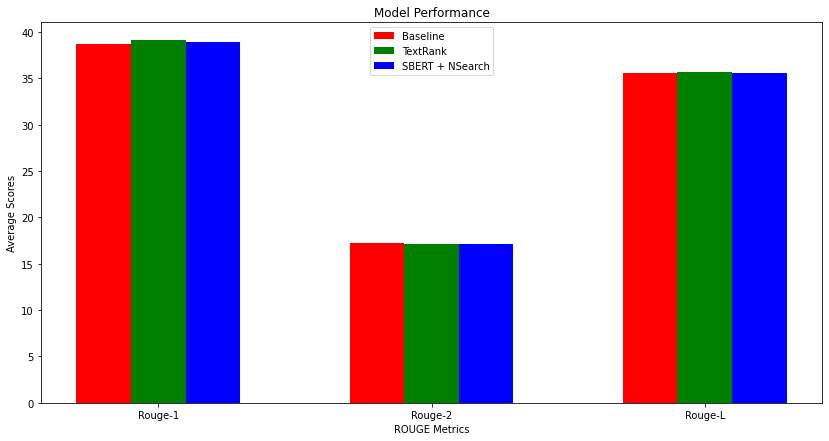

In [ ]:
if SUMMARISE == False:

  # Plot the ROUGE scores of the models together
  N = 3
  ind = np.arange(N) 
  width = 0.2

  plt.figure(figsize=(14, 7))
    
  vals1 = [df['Average Rouge_1'][0], df['Average Rouge_2'][0], df['Average Rouge_L'][0]]
  bar1 = plt.bar(ind, vals1, width, color = 'r')
    
  vals2 = [df['Average Rouge_1'][1], df['Average Rouge_2'][1], df['Average Rouge_L'][1]]
  bar2 = plt.bar(ind+width, vals2, width, color='g')
    
  vals3 = [df['Average Rouge_1'][2], df['Average Rouge_2'][2], df['Average Rouge_L'][2]]
  bar3 = plt.bar(ind+width*2, vals3, width, color = 'b')
    
  plt.xlabel('ROUGE Metrics')
  plt.ylabel('Average Scores')
  plt.title('Model Performance')
    
  plt.xticks(ind+width, ['Rouge-1', 'Rouge-2', 'Rouge-L'])
  plt.legend((bar1, bar2, bar3), names)
  plt.show()